In [1]:
import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
import math
from PIL import Image

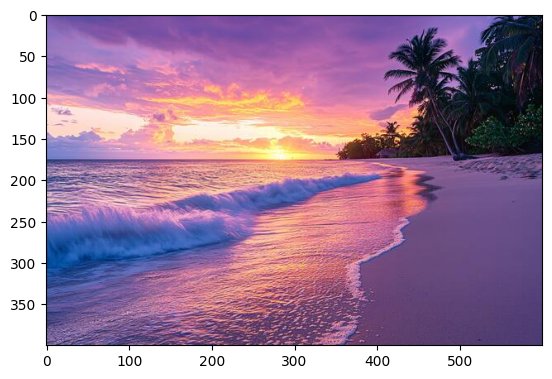

In [2]:
img = plt.imread('./image.jpg')
plt.imshow(img)
plt.show()

[0. 1.]


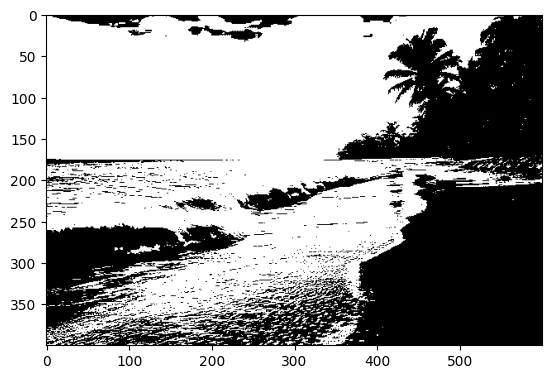

In [3]:
@cuda.jit(device=True)
def binarization(theta_x_y, tau):
    theta_x_y = (1/ 3) * (theta_x_y[0] + theta_x_y[1] + theta_x_y[2])
    if theta_x_y < tau:
        b_x_y = 0
    else:
        b_x_y = 1
    return b_x_y

@cuda.jit
def kernel_binarization(src, tau, dst):
    tid_y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    tid_x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    for d in range(src.shape[2]):
        dst[tid_y, tid_x, d] = binarization(src[tid_y, tid_x], tau)

src = cuda.to_device(img.astype(np.uint8))
dst = cuda.device_array(img.shape, dtype=np.float32) 
h, w, _ = img.shape
TAU = 120

threadsperblock = (32, 32)
blockspergrid_x = math.ceil(w / threadsperblock[0])
blockspergrid_y = math.ceil(h / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

kernel_binarization[blockspergrid, threadsperblock](src, TAU, dst)
output = dst.copy_to_host()
print(np.unique(output))
plt.imshow(output)
plt.show()

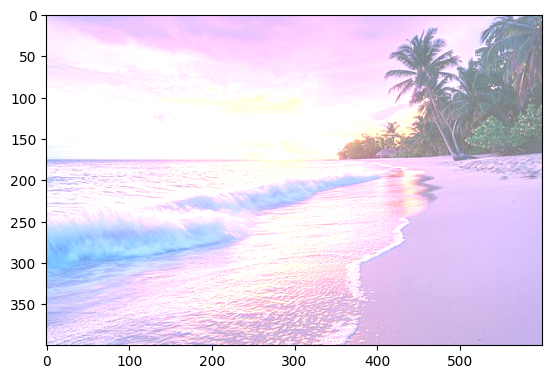

In [4]:
@cuda.jit(device=True)
def brightness_control(theta_x_y, value):
    return theta_x_y + value

@cuda.jit
def kernel_brightness_control(src, dst):
    tid_y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    tid_x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    for d in range(src.shape[2]):
        dst[tid_y, tid_x, d] = brightness_control(src[tid_y, tid_x, d], 120)

src = cuda.to_device(img.astype(np.uint8))
dst = cuda.device_array(img.shape, dtype=np.int32) 
h, w, _ = img.shape

threadsperblock = (32, 32)
blockspergrid_x = math.ceil(w / threadsperblock[0])
blockspergrid_y = math.ceil(h / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

kernel_brightness_control[blockspergrid, threadsperblock](src, dst)
output = dst.copy_to_host()
output = np.clip(output, 0, 255).astype("uint8")
plt.imshow(output)
plt.show()

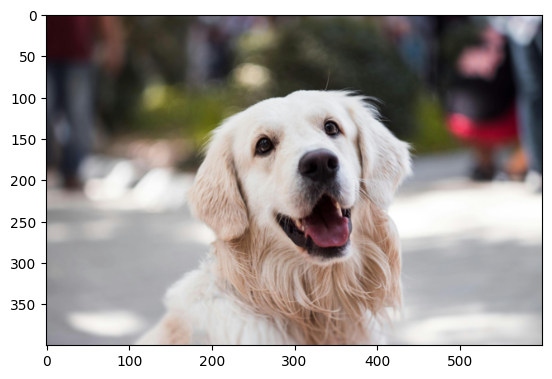

In [5]:
img1 = plt.imread('image.jpg')
img2 = Image.open('image2.jpg')
img2_resized = img2.resize((img1.shape[1], img1.shape[0]))
img2_resized = np.array(img2_resized)
plt.imshow(img2_resized)
plt.show()

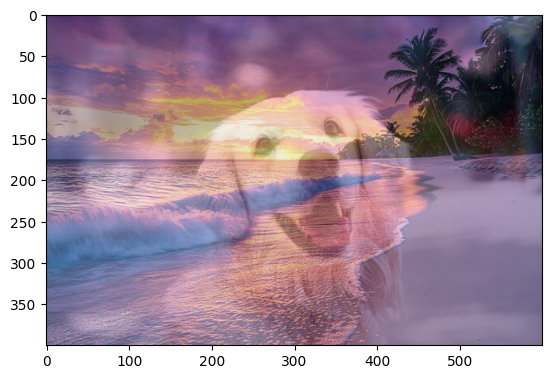

In [6]:
@cuda.jit(device=True)
def blending(theta1_x_y, theta2_x_y, c):
    return c * theta1_x_y + (1-c) * theta2_x_y

@cuda.jit
def kernel_blending(src1, src2, c, dst):
    tid_y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    tid_x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    for d in range(src1.shape[2]):
        dst[tid_y, tid_x, d] = blending(src1[tid_y, tid_x, d], src2[tid_y, tid_x, d], c)

src1 = cuda.to_device(img1.astype(np.float32))
src2 = cuda.to_device(img2_resized.astype(np.float32))
dst = cuda.device_array(img.shape, dtype=np.float32) 
h, w, _ = img.shape

threadsperblock = (32, 32)
blockspergrid_x = math.ceil(w / threadsperblock[0])
blockspergrid_y = math.ceil(h / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

WEIGHT = 0.6
kernel_blending[blockspergrid, threadsperblock](src1, src2, WEIGHT, dst)
output = dst.copy_to_host()
output = np.clip(output, 0, 255).astype("uint8")
plt.imshow(output)
plt.show()